In [39]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
import random

In [2]:
experiment_id = "Dop8V030"
# round_ids = ["ARN", "R01", "R01CS", "R02N", "R02F", "R02S", "R02SF"]
# round_ids = ["ARN", "R01", "R01CS", "R02N"]
round_ids = ["ARN", "R01", "R01CS", "R02N", "R02F", "R02S", "R02SF"]

dtype = torch.float32

In [3]:
sequences = []
for round_id in round_ids:
    s = utils.sequences_from_file(experiment_id, round_id, device=torch.device("cpu"))
    sequences.append(s)
    print(f"finished {round_id}")

finished ARN
finished R01
finished R01CS
finished R02N
finished R02F
finished R02S
finished R02SF


In [4]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=torch.device("cpu")) for seq in sequences]

In [5]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [123]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/home/scrotti/Aptamer2025py/callback.py'>

In [124]:
tr = tree.Tree()
# tr.add_node(-1, name = "R01")
tr.add_node(-1, name = "R02N")
tr.add_node(-1, name = "R02F")
tr.add_node(-1, name = "R02S")
tr.add_node(-1, name = "R02SF")

picked_round_idx = [1, 3, 4, 5, 6]

mode_names = ["NA, NW", "FA, NW", "NA, HW", "FA, HW"]

selected_modes = torch.BoolTensor(
    [
     # [1, 0, 0, 0],
     [1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]
)

n_selection_rounds, n_modes = selected_modes.size()
assert n_selection_rounds == len(picked_round_idx) - 1
n_rounds = n_selection_rounds + 1

In [125]:
L, q = sequences_oh[0][0].shape

k = torch.randn(L, q, dtype=dtype)
K = utils.rand_coupling_matrix(L, q, dtype=dtype, rescaling=1e-4)
h = torch.randn(L, q, dtype=dtype)
J = utils.rand_coupling_matrix(L, q, dtype=dtype, rescaling=1e-4)
potts = energy_models.Potts(J, h)
potts_modes = [potts for _ in range(n_modes - 1)]

Ns0 = energy_models.Potts(K, k)

unbound_mode = energy_models.ConstantEnergy(-10)

ps = selex_distribution.MultiModeDistribution(*potts_modes, unbound_mode, normalized=True)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes, 
                                                  learn_selection_strength=True,
                                                  selection_strength = torch.rand(n_selection_rounds, dtype=dtype))

In [126]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [127]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(sequences_oh[id], batch_size=batch_size, device=device) 
                for id in picked_round_idx]

In [128]:
n_chains = 10**5

chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [129]:
callbacks = [callback.ConvergenceMetricsCallback()]

In [141]:
model_device = model.to(device)
chains_device = chains.to(device)
total_reads_device = total_reads.to(device)
log_weights_device = log_weights.to(device)
optimizer = torch.optim.Adam(model_device.parameters(), lr=0.005)

In [ ]:
n_sweeps = 10
target_pearson = 1
max_epochs = 300

training.train(model_device, data_loaders, total_reads_device, chains_device, n_sweeps, lr, max_epochs, target_pearson, 
               callbacks=callbacks, log_weights=log_weights_device, optimizer=optimizer)

 0.00%[                                           ] Epoch: 0/300 [00:00, ?it/s]

In [ ]:
model = model_device.to(torch.device('cpu'))
chains = chains_device.to(torch.device('cpu'))
total_reads = total_reads_device.to(torch.device('cpu'))
log_weights = log_weights_device.to(torch.device('cpu'))

del model_device, chains_device, total_reads_device, log_weights_device
torch.cuda.empty_cache()

import gc
gc.collect()

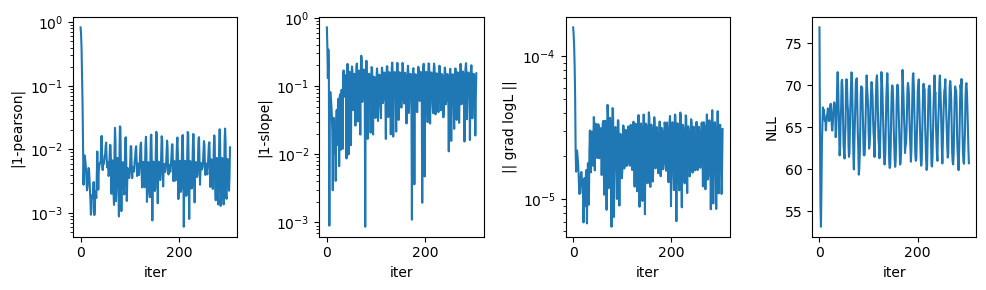

In [152]:
callbacks[0].plot();

In [153]:
model.selection_strength

Parameter containing:
tensor([8.9371e-01, 1.4191e-03, 5.3999e-01, 1.4335e+00], requires_grad=True)

In [154]:
alpha_last4 = model.selection_strength.clone()[-4:]
alpha_last4 /= alpha_last4.sum()
alpha_last4

tensor([3.1155e-01, 4.9469e-04, 1.8824e-01, 4.9972e-01],
       grad_fn=<AsStridedBackward0>)

In [155]:
torch.tensor([0.3045, 0.1938, 0.2712, 0.2305])

tensor([0.3045, 0.1938, 0.2712, 0.2305])

Plottare scatter con logps

In [156]:
X = sequences_oh[0]

In [ ]:
logps_modes = []
for i in range(len(model.selection_strength)):
    logps = model.selection.modes[0].compute_energy(X).detach() * torch.abs(model.selection_strength[i].detach())
    logps_modes.append(logps)
    print(f"finished {i+1}-th mode")

In [ ]:
mode_labels = ['norm A, norm W', 'fast A, norm W', 'norm A, high W', 'fast A, high W']

In [ ]:
fig, axes = plt.subplots(n_modes, n_modes, 
                         # sharex=True, sharey=True, 
                         figsize=(7,6)
                        )
N = 10**4

for i in range(n_modes):
    for j in range(n_modes):
        ax = axes[i,j]
        x = logps_modes[i]
        y = logps_modes[j]
        idx = random.sample(range(len(x)), min(N, len(x)))
        sl = torch.abs(model.selection_strength[j].detach()) / torch.abs(model.selection_strength[i].detach())
        ax.scatter(x[idx], y[idx], s=2, label=f'slope={sl:.4f}')
        ax.legend(loc='lower right')
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(mode_labels[i])
        ax.set_ylabel(mode_labels[j])
fig.suptitle('logps')
fig.tight_layout()